In [19]:
# Import thư viện
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
import joblib
import os

# Cấu hình font cho biểu đồ
import matplotlib 
plt.style.use('default')
font = {'family' : 'DejaVu Sans', 'weight' : 'normal', 'size' : 18}
matplotlib.rc('font', **font)

In [20]:
def getDataNormalization(num_samples):
    save_folder = 'train_0.5_valid_0.7_test'
    train_data = pd.read_csv('../data/' + save_folder + '/train_data_' + str(num_samples) + '_Normalization.csv')
    X_train = train_data.drop(['Species'], axis = 1).values
    y_train = train_data[['Species']].copy().values
    valid_data = pd.read_csv('../data/' + save_folder + '/train_data_' + str(num_samples) + '_valid.csv')
    X_valid = valid_data.drop(['Species'], axis = 1).values
    y_valid = valid_data[['Species']].copy().values
    
    y_train = np.floor(y_train + 1.1).astype(int).squeeze()
    y_valid = np.floor(y_valid + 1.1).astype(int).squeeze()
    
    return X_train, np.eye(3)[y_train], X_valid, np.eye(3)[y_valid]

def getTestDataset(num_samples):
    save_folder = 'train_0.5_valid_0.7_test'
    test_data = pd.read_csv('../data/' + save_folder + '/train_data_' + str(num_samples) + '_test.csv')
    X_test = test_data.drop(['Species'], axis = 1).values
    y_test = test_data[['Species']].copy().values
    y_test = np.floor(y_test + 1.1).astype(int).squeeze()
    return X_test, np.eye(3)[y_test]

In [21]:
n_estimators_list = [10, 20, 30]
sample_sizes = [50, 110, 170]
all_scores = {n: [] for n in n_estimators_list}
models = {} # Store for later visualization

for size in sample_sizes:
    X_train, y_train, X_valid, y_valid = getDataNormalization(size)
    for n in n_estimators_list:
        model = RandomForestClassifier(n_estimators=n, criterion='entropy', random_state=8500)
        model.fit(X_train, y_train)
        y_pred = np.argmax(model.predict(X_valid), axis=1)
        score = metrics.accuracy_score(np.argmax(y_valid, axis=1), y_pred)
        all_scores[n].append(score)
        
        path = f'../results/model/data_Normalization/random_forest/{size}_samples/'
        os.makedirs(path, exist_ok=True)
        joblib.dump(model, f'{path}{size}_samples_{n}_trees_data_Normalization.joblib')
        models[f"{size}_{n}"] = model

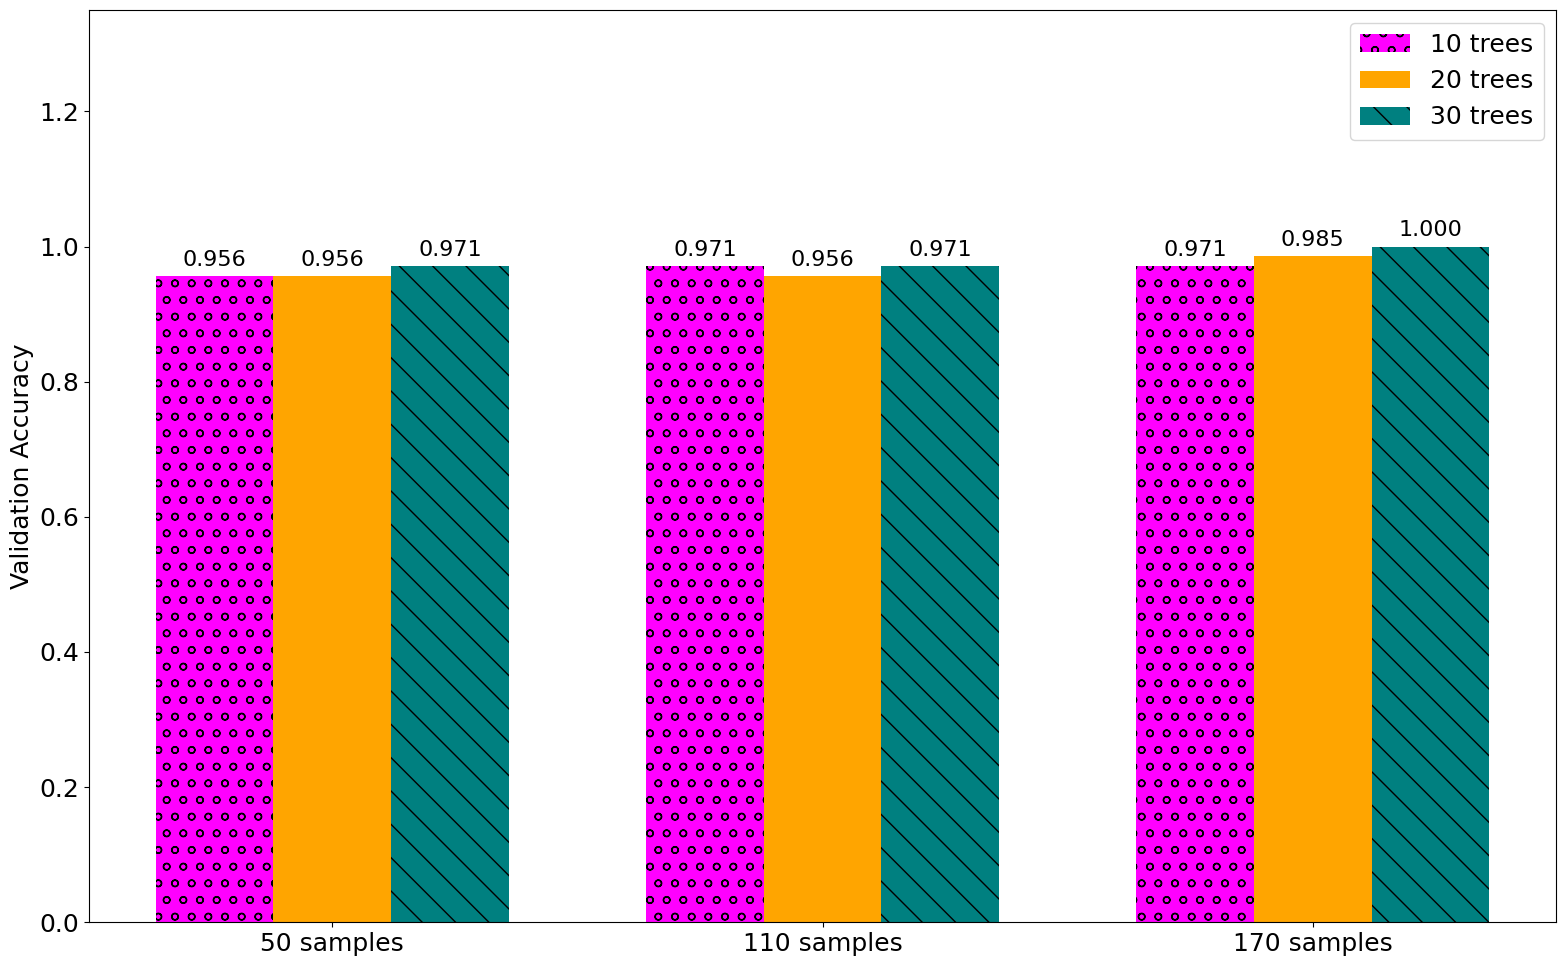

In [26]:
objects = ('50 samples', '110 samples', '170 samples')
y_pos = np.arange(len(objects))
plt.figure(figsize=(16, 10))

colors = ['magenta', 'orange', 'teal']
patterns = ['o', '', '\\']
widths = [-0.24, 0, 0.24]

for i, n in enumerate(n_estimators_list):
    acc_list = all_scores[n]
    bars = plt.bar(y_pos + widths[i], acc_list, 0.24, label=f'{n} trees', color=colors[i], hatch=patterns[i])
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', ha='center', va='bottom', fontsize=16)

plt.xticks(y_pos, objects)
plt.ylim([0, 1.35]) # Cao hơn để không chạm Legend
plt.ylabel("Validation Accuracy")
plt.legend(loc='upper right', fontsize=18)
plt.tight_layout()

pic_folder = '../pics/random_forest/'
os.makedirs(pic_folder, exist_ok=True)
plt.savefig(pic_folder + 'rf_variant_data_size.pdf', bbox_inches='tight')
plt.savefig(pic_folder + 'rf_variant_data_size.svg', bbox_inches='tight')
plt.show()

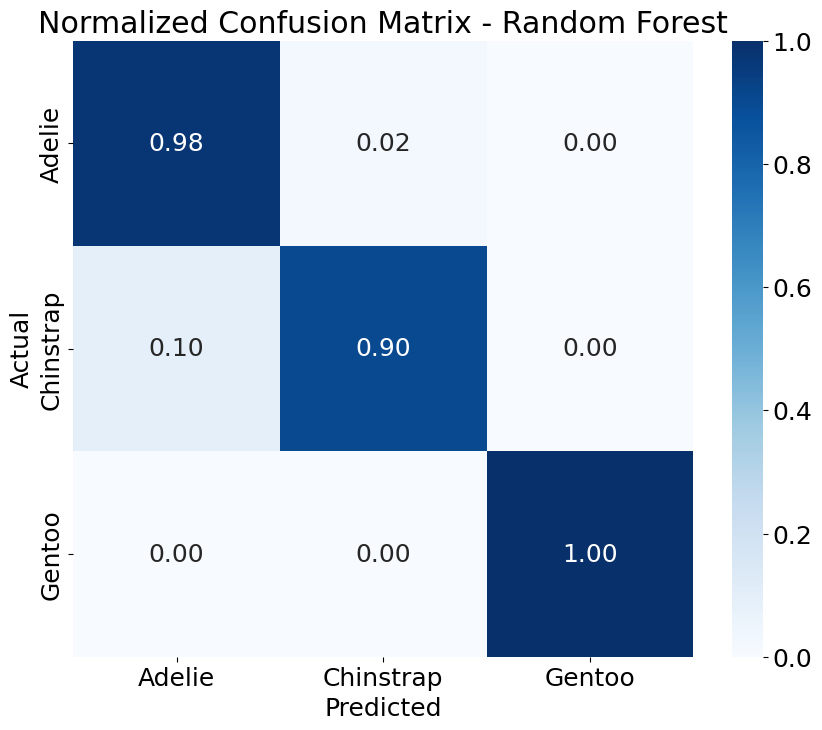

In [ ]:
labels = ["Adelie", "Chinstrap", "Gentoo"]
# Lấy model tốt nhất (170 samples, 30 trees)
best_model = models["170_30"]
X_test, y_test = getTestDataset(170)
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
# Chuẩn hóa ma trận
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix - Random Forest')
plt.savefig(pic_folder + 'rf_confusion_matrix.pdf', bbox_inches='tight')
plt.savefig(pic_folder + 'rf_confusion_matrix.svg', bbox_inches='tight')
plt.show()

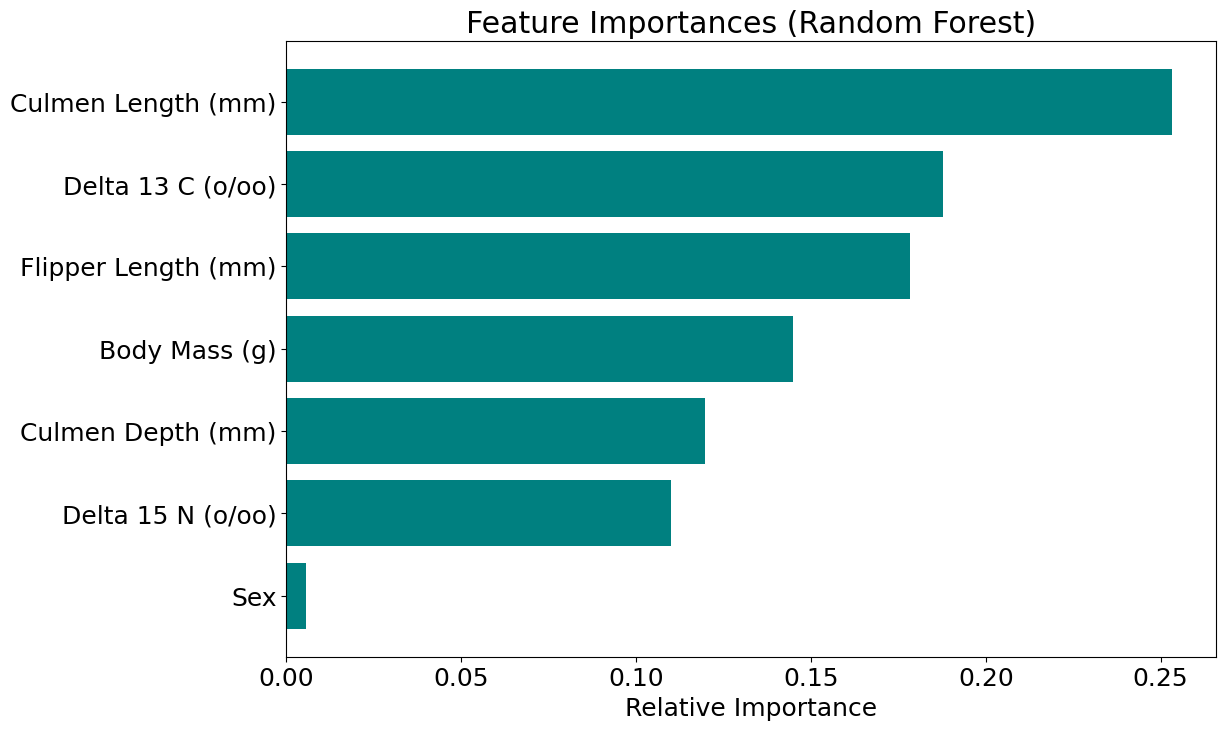

In [24]:
feature_names = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Sex']
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Feature Importances (Random Forest)')
plt.savefig(pic_folder + 'rf_feature_importance.pdf', bbox_inches='tight')
plt.savefig(pic_folder + 'rf_feature_importance.svg', bbox_inches='tight')
plt.show()

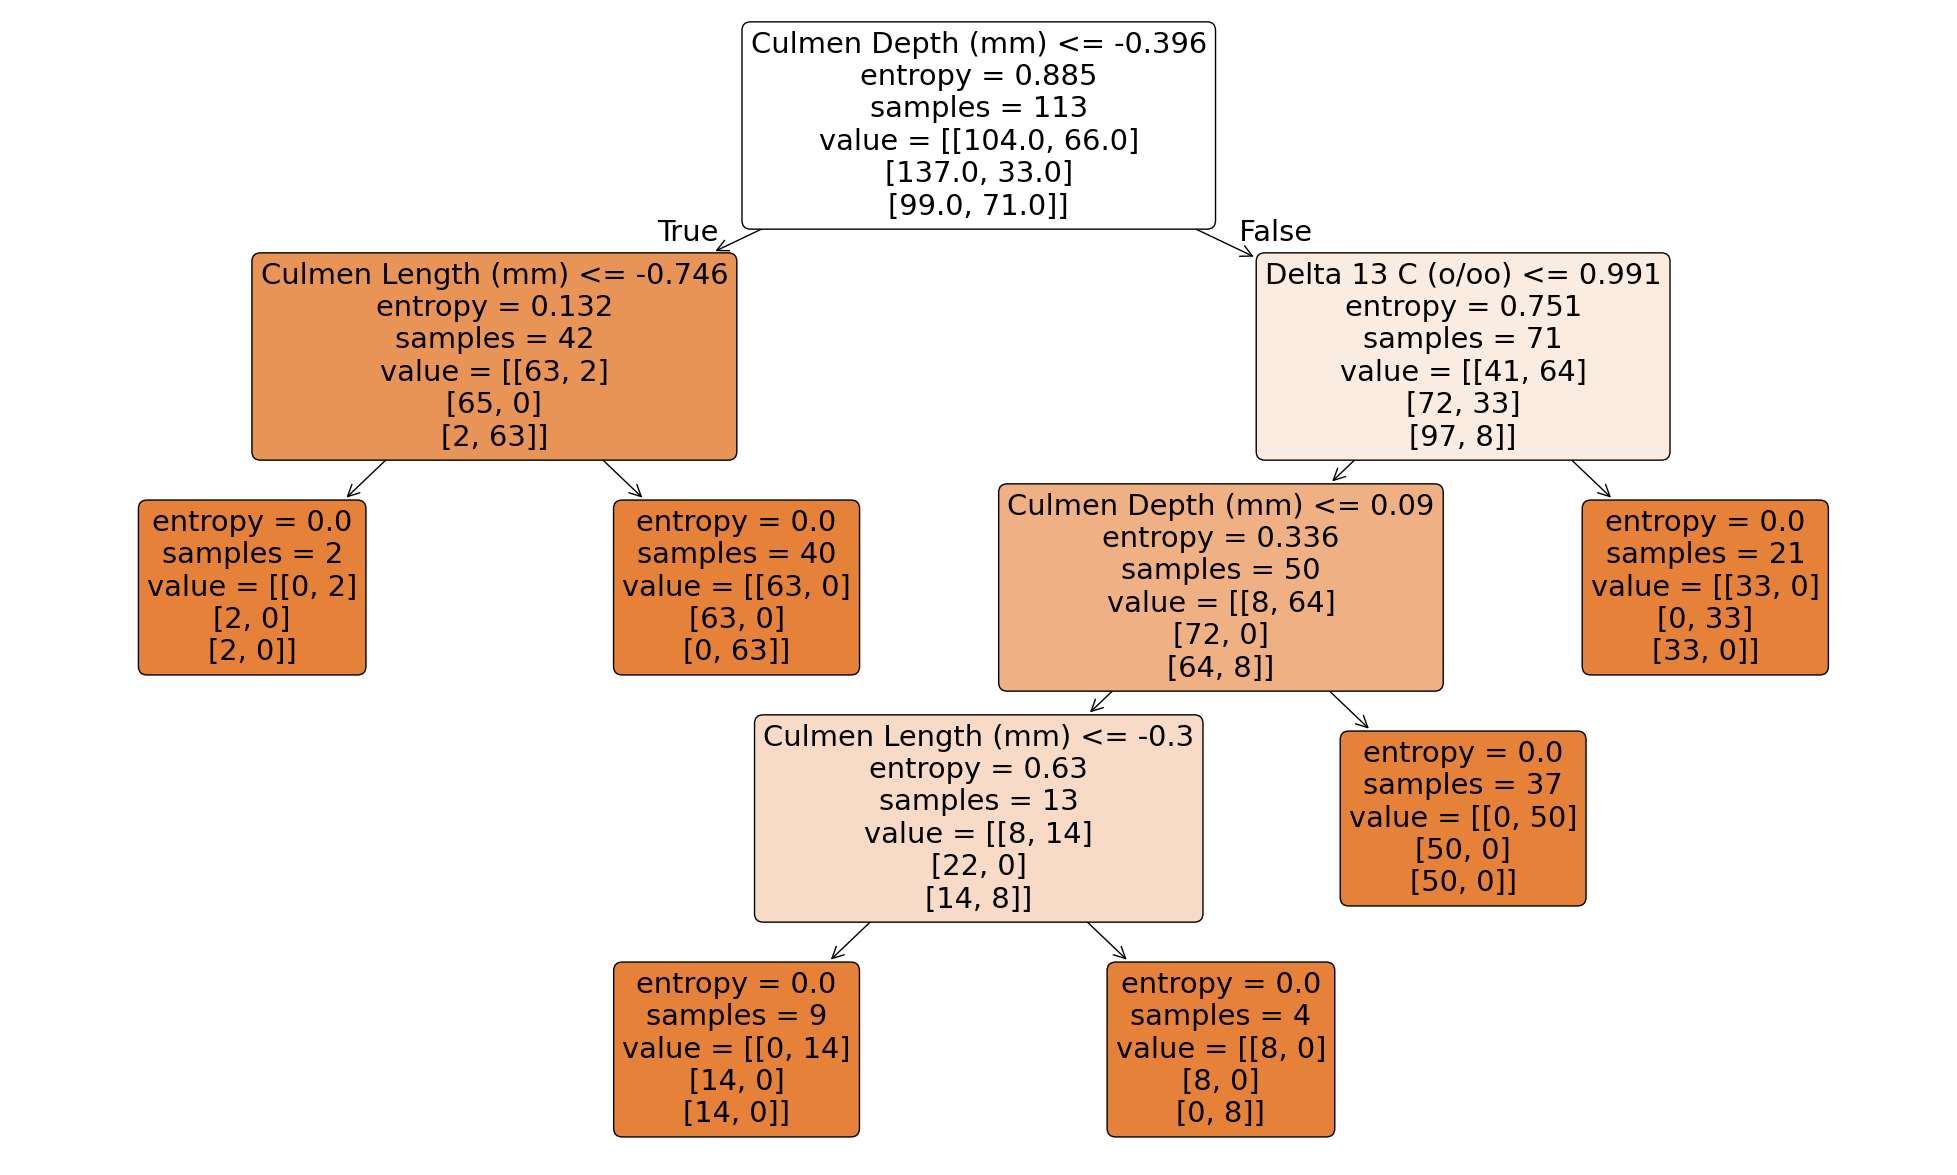

In [28]:
plt.figure(figsize=(25, 15))
plot_tree(best_model.estimators_[0], 
          feature_names=feature_names, 
          class_names=labels, 
          filled=True, rounded=True)
plt.savefig(pic_folder + 'rf_single_tree_logic.pdf', bbox_inches='tight')
plt.savefig(pic_folder + 'rf_single_tree_logic.svg', bbox_inches='tight')
plt.show()